# Plot Visitation Totals

#### Primary Authors:
Chris Carey, Nuoyi Wang

#### Description:
This notebook plots the total food location visitations over time.

#### Inputs:
```
exports/home_weekly.csv
```

#### Visualizations:
> Time-series plot total food location visitations

In [1]:
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pytz

import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from datetime import datetime
import dateutil.tz

import warnings
warnings.filterwarnings('ignore')

In [2]:
FONT_SIZE_TICKS=13
FONT_SIZE_AXIS=14
FONT_SIZE_TITLE=16
FONT_SIZE_LEGEND=14
tzinfo = pytz.timezone('US/Eastern')

In [3]:
# First week of 2019.
DATE_START = pd.to_datetime('2018-12-31 00:00:00-05:00')
# Last week of 2020.
DATE_END = pd.to_datetime('2020-01-25 00:00:00-05:00')

# First week of 2020.
DATE_START_PLOT = pd.to_datetime('2019-12-30 00:00:00-05:00')
# CUTOFF BEFORE DATA GAP
DATE_END_PLOT = pd.to_datetime('2020-11-23 00:00:00-05:00')

# Start of COVID-19 Pre-Pandemic Period
DATE_START_PRE_COVID = pd.to_datetime('2019-03-18 00:00:00-04:00')
DATE_END_PRE_COVID = pd.to_datetime('2019-11-25 00:00:00-05:00')

# Start of COVID-19 Pandemic Period
DATE_START_COVID = pd.to_datetime('2020-03-16 00:00:00-04:00')
DATE_END_COVID = pd.to_datetime('2020-11-23 00:00:00-05:00')

# First week of 2019 - 1 week.
DATE_START_ROLLING = pd.to_datetime('2018-12-24 00:00:00-05:00')
# Last week of 2020 + 1 week.
DATE_END_ROLLING = pd.to_datetime('2021-02-01 00:00:00-05:00')

In [4]:
# https://cran.r-project.org/web/packages/khroma/vignettes/tol.html + NYU
COLORS = ['#57068c', '#e0b6fc', '#825', '#173', '#dc7', '#4a9', '#c67', '#993', '#a49']

In [5]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [6]:
def repair_dates(df, date_column='date_range_start'):
    df[date_column] = pd.to_datetime(df[date_column], utc=True)
    df[date_column] = df[date_column].dt.tz_convert('US/Eastern')

In [7]:
def repair_dt_index(df):
    df = df.sort_values(by=['date_range_start'])
    dt_index = pd.date_range(df.loc[0, 'date_range_start'], df.loc[len(df) - 1, 'date_range_start'], freq='W-MON')
    df = df.set_index('date_range_start')
    df = df.reindex(dt_index)
    return df

In [8]:
def smoothen(df, columns=[], N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_groupby = df.copy()
    rolling_df = rolling_groupby[columns].rolling(N + 1, center=True).mean()
    rolling_df = rolling_df.reset_index()
    rolling_df = rolling_df.sort_values(by=['index'])
    rolling_df = rolling_df.set_index(['index'])
    return rolling_df

In [9]:
home_weekly_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_weekly_df)
home_weekly_df = home_weekly_df.rename(columns={'home_cbg': 'cbg'})
peek(home_weekly_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.250000,0.250000,20.076046
1,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050210021,4,6.697436,0.013158,0.013158,0.509311
2,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360470285021,4,7.414691,0.007273,0.007273,0.563855


27738422


In [10]:
total_df = home_weekly_df.groupby(by=['date_range_start']).agg({
    'visitor_count': 'sum',
    'estimated_visitor_count': 'sum'
}).reset_index()
total_df = repair_dt_index(total_df)
total_df = smoothen(total_df,
                    columns=['visitor_count', 'estimated_visitor_count'])
total_df

,visitor_count,estimated_visitor_count
index,,
2018-12-31 00:00:00-05:00,NaN,NaN
2019-01-07 00:00:00-05:00,1.345694e+06,2.987885e+06
2019-01-14 00:00:00-05:00,1.364274e+06,2.999605e+06
2019-01-21 00:00:00-05:00,1.378141e+06,3.057874e+06
2019-01-28 00:00:00-05:00,1.399974e+06,3.128813e+06
...,...,...
2021-01-18 00:00:00-05:00,5.099867e+05,2.244652e+06
2021-01-25 00:00:00-05:00,4.777530e+05,2.130302e+06
2021-02-01 00:00:00-05:00,4.851440e+05,2.176345e+06


In [11]:
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

def thousands(x, pos):
    return '%1.0fK' % (x * 1e-3)

In [12]:
covid_df = pd.read_csv('./data/cases-by-day.csv')
covid_df = covid_df.rename(columns={
    'CASE_COUNT': 'case_count',
    'date_of_interest': 'date',
})
covid_df = covid_df[['date', 'case_count']]
covid_df['date'] = pd.to_datetime(covid_df['date']).dt.tz_localize('US/Eastern')
covid_df['week'] = covid_df['date'].dt.week
covid_df = covid_df.groupby(by=['week']).agg({
    'date': 'first',
    'case_count': 'sum',
}).reset_index()
covid_df = covid_df.sort_values(by=['date'])
covid_df[['case_count']] = covid_df[['case_count']].rolling(3, center=True).mean()
# Drop first week. It doesn't start on Monday and it's NaN due to rolling average.
covid_df = covid_df.iloc[1:, :]
covid_df = covid_df.set_index('date')

In [13]:
total_and_covid_df = total_df.merge(covid_df, left_index=True, right_index=True, how='outer')
peek(total_and_covid_df)

,visitor_count,estimated_visitor_count,week,case_count
2018-12-31 00:00:00-05:00,NaN,NaN,NaN,NaN
2019-01-07 00:00:00-05:00,1.345694e+06,2.987885e+06,NaN,NaN
2019-01-14 00:00:00-05:00,1.364274e+06,2.999605e+06,NaN,NaN


113


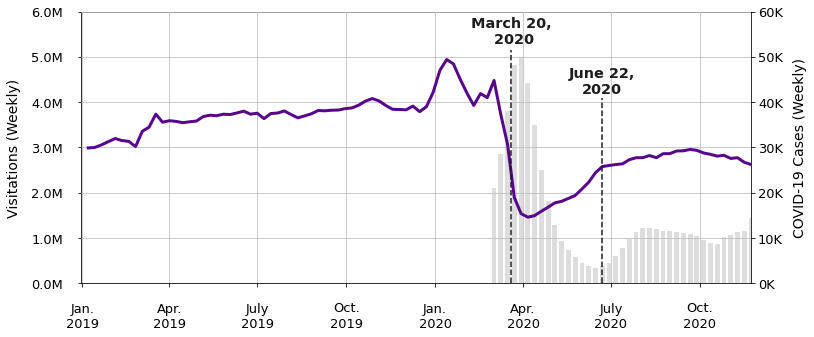

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
bar_ax = ax.twinx()

bar_ax.bar(total_and_covid_df.index, total_and_covid_df['case_count'], width=5, color='#ddd')

ax.plot(total_and_covid_df.index, total_and_covid_df['estimated_visitor_count'], linewidth=3, color=COLORS[0])

ax.set_zorder(1)
ax.set_frame_on(False)

ax.axvline(
    pd.to_datetime('2020-03-20 00:00:00-05:00'),
    0, 0.86, color='#1d1d1d', linestyle='dashed')
ax.text(
    pd.to_datetime('2020-03-20 00:00:00-05:00'),
         5.3e6,
         "March 20,\n 2020",
         horizontalalignment='center',
         size='x-large',
         color='#1d1d1d',
         weight='semibold')

ax.axvline(
    pd.to_datetime('2020-06-22 00:00:00-05:00'),
    0, 0.68, color='#1d1d1d', linestyle='dashed')
ax.text(
    pd.to_datetime('2020-06-22 00:00:00-05:00'),
         4.2e6,
         "June 22,\n2020",
         horizontalalignment='center',
         size='x-large',
         color='#1d1d1d',
         weight='semibold')


m_formatter = FuncFormatter(millions)
k_formatter = FuncFormatter(thousands)

ax.set_xlabel('')
ax.set_ylabel('Visitations (Weekly)', fontsize=FONT_SIZE_AXIS, labelpad=10)

bar_ax.set_ylabel('COVID-19 Cases (Weekly)', fontsize=FONT_SIZE_AXIS, labelpad=10)

ax.yaxis.set_major_formatter(m_formatter)
bar_ax.yaxis.set_major_formatter(k_formatter)

ax.xaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)
ax.yaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)
bar_ax.yaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)

ax.set_facecolor('#ffffff')
ax.grid(color='#bdbdbd')
ax.set_ylim([0, 6000000])
ax.set_xlim([
    DATE_START,
    DATE_END_PLOT,
])
bar_ax.set_ylim([0, 60000])

plt.setp(ax.spines.values(), color='#000000')
ax.tick_params(axis='x', which='major', pad=15)
ax.tick_params(axis='y', which='major', pad=15)

ax.set_xticks([
    pd.to_datetime('2019-01-01 00:00:00-05:00'),
    pd.to_datetime('2019-04-01 00:00:00-05:00'),
    pd.to_datetime('2019-07-01 00:00:00-05:00'),
    pd.to_datetime('2019-10-01 00:00:00-05:00'),
    pd.to_datetime('2020-01-01 00:00:00-05:00'),
    pd.to_datetime('2020-04-01 00:00:00-05:00'),
    pd.to_datetime('2020-07-01 00:00:00-05:00'),
    pd.to_datetime('2020-10-01 00:00:00-05:00'),
]),
ax.set_xticklabels([
    'Jan.\n2019',
    'Apr.\n2019',
    'July\n2019',
    'Oct.\n2019',
    'Jan.\n2020',
    'Apr.\n2020',
    'July\n2020',
    'Oct.\n2020',
],
                   rotation=0,
                   ha='center')
plt.show()

In [23]:
tc2019_df = total_and_covid_df[(total_and_covid_df.index >= DATE_START_PRE_COVID) & (total_and_covid_df.index <= DATE_END_PRE_COVID)].reset_index()
tc2020_df = total_and_covid_df[(total_and_covid_df.index >= DATE_START_COVID) & (total_and_covid_df.index <= DATE_END_COVID)].reset_index()
peek(tc2019_df)
peek(tc2020_df)
tc_pct_df = tc2020_df.copy()
tc_pct_df['estimated_visitor_count'] = (tc2020_df['estimated_visitor_count'] - tc2019_df['estimated_visitor_count']) / tc2019_df['estimated_visitor_count']
tc_pct_df = tc_pct_df.set_index(tc_pct_df['index'])
tc_pct_df.head()

,index,visitor_count,estimated_visitor_count,week,case_count
0,2019-03-18 00:00:00-04:00,1.421651e+06,3.734434e+06,NaN,NaN
1,2019-03-25 00:00:00-04:00,1.436181e+06,3.555833e+06,NaN,NaN
2,2019-04-01 00:00:00-04:00,1.482080e+06,3.589636e+06,NaN,NaN


37


,index,visitor_count,estimated_visitor_count,week,case_count
0,2020-03-16 00:00:00-04:00,806620.333333,3.069896e+06,12.0,38076.666667
1,2020-03-23 00:00:00-04:00,533296.666667,1.897657e+06,13.0,48178.666667
2,2020-03-30 00:00:00-04:00,432440.666667,1.539165e+06,14.0,49926.333333


37


,index,visitor_count,estimated_visitor_count,week,case_count
index,,,,,
2020-03-16 00:00:00-04:00,2020-03-16 00:00:00-04:00,806620.333333,-0.177949,12.0,38076.666667
2020-03-23 00:00:00-04:00,2020-03-23 00:00:00-04:00,533296.666667,-0.466326,13.0,48178.666667
2020-03-30 00:00:00-04:00,2020-03-30 00:00:00-04:00,432440.666667,-0.571220,14.0,49926.333333
2020-04-06 00:00:00-04:00,2020-04-06 00:00:00-04:00,409172.666667,-0.591572,15.0,44275.000000
2020-04-13 00:00:00-04:00,2020-04-13 00:00:00-04:00,407639.000000,-0.578621,16.0,34925.666667


In [24]:
tc_pct_df.tail()

,index,visitor_count,estimated_visitor_count,week,case_count
index,,,,,
2020-10-26 00:00:00-04:00,2020-10-26 00:00:00-04:00,697798.000000,-0.307279,44.0,10181.000000
2020-11-02 00:00:00-05:00,2020-11-02 00:00:00-05:00,671138.333333,-0.315337,45.0,10582.000000
2020-11-09 00:00:00-05:00,2020-11-09 00:00:00-05:00,658010.000000,-0.293596,46.0,11238.666667
2020-11-16 00:00:00-05:00,2020-11-16 00:00:00-05:00,620021.666667,-0.304633,47.0,11451.333333
2020-11-23 00:00:00-05:00,2020-11-23 00:00:00-05:00,598989.666667,-0.316275,48.0,14341.666667


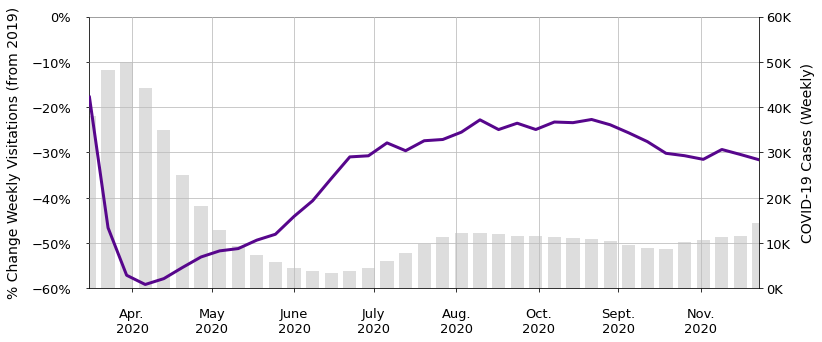

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
bar_ax = ax.twinx()

bar_ax.bar(tc_pct_df.index, tc_pct_df['case_count'], width=5, color='#ddd')

ax.plot(tc_pct_df.index, tc_pct_df['estimated_visitor_count'], linewidth=3, color=COLORS[0])

ax.set_zorder(1)
ax.set_frame_on(False)

m_formatter = FuncFormatter(millions)
k_formatter = FuncFormatter(thousands)

ax.set_xlabel('')
ax.set_ylabel('% Change Weekly Visitations (from 2019)', fontsize=FONT_SIZE_AXIS, labelpad=10)

bar_ax.set_ylabel('COVID-19 Cases (Weekly)', fontsize=FONT_SIZE_AXIS, labelpad=10)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
bar_ax.yaxis.set_major_formatter(k_formatter)

ax.xaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)
ax.yaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)
bar_ax.yaxis.set_tick_params(labelsize=FONT_SIZE_TICKS)

ax.set_facecolor('#ffffff')
ax.grid(color='#bdbdbd')
ax.set_ylim([-0.6, 0])
ax.set_xlim([
    DATE_START_COVID,
    DATE_END_PLOT,
])
bar_ax.set_ylim([0, 60000])

plt.setp(ax.spines.values(), color='#000000')
ax.tick_params(axis='x', which='major', pad=15)
ax.tick_params(axis='y', which='major', pad=15)

ax.set_xticks([
    pd.to_datetime('2020-04-01 00:00:00-05:00'),
    pd.to_datetime('2020-05-01 00:00:00-05:00'),
    pd.to_datetime('2020-06-01 00:00:00-05:00'),
    pd.to_datetime('2020-07-01 00:00:00-05:00'),
    pd.to_datetime('2020-08-01 00:00:00-05:00'),
    pd.to_datetime('2020-09-01 00:00:00-05:00'),
    pd.to_datetime('2020-10-01 00:00:00-05:00'),
    pd.to_datetime('2020-11-01 00:00:00-05:00'),
]),
ax.set_xticklabels([
    'Apr.\n2020',
    'May\n2020',
    'June\n2020',
    'July\n2020',
    'Aug.\n2020',
    'Oct.\n2020',
    'Sept.\n2020',
    'Nov.\n2020',
],
                   rotation=0,
                   ha='center')
plt.show()

In [26]:
covid_df

,week,case_count
date,,
2020-03-02 00:00:00-05:00,10,21099.666667
2020-03-09 00:00:00-04:00,11,28515.333333
2020-03-16 00:00:00-04:00,12,38076.666667
2020-03-23 00:00:00-04:00,13,48178.666667
2020-03-30 00:00:00-04:00,14,49926.333333
2020-04-06 00:00:00-04:00,15,44275.000000
2020-04-13 00:00:00-04:00,16,34925.666667
2020-04-20 00:00:00-04:00,17,25071.000000
2020-04-27 00:00:00-04:00,18,18144.333333


In [27]:
def plot(light=True):
    bg_color = '#fff' if light else '#191a1a'
    grid_color = '#bdbdbd' if light else '#555'
    spine_color = '#000' if light else '#fff'
    text_color = '#000' if light else '#fff'
    
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.bar(covid_df.index, covid_df['case_count'], width=5, color='#999', zorder=2)

    k_formatter = FuncFormatter(thousands)

    ax.set_xlabel('')

    ax.set_ylabel('NYC COVID-19 Cases (Weekly)', fontsize=FONT_SIZE_AXIS, labelpad=10, color=text_color)

    ax.yaxis.set_major_formatter(k_formatter)

    ax.xaxis.set_tick_params(labelsize=FONT_SIZE_TICKS, color=text_color)
    ax.yaxis.set_tick_params(labelsize=FONT_SIZE_TICKS, color=text_color)
    
    ax.grid(color=grid_color, zorder=1)
    ax.set_xlim([
        pd.to_datetime('2020-01-01 00:00:00-05:00'),
        pd.to_datetime('2021-01-01 00:00:00-05:00'),
    ])
    
    plt.setp(ax.spines.values(), color=spine_color)
    ax.tick_params(axis='x', which='major', pad=15, colors=text_color)
    ax.tick_params(axis='y', which='major', pad=15, colors=text_color)

    ax.set_xticks([
        pd.to_datetime('2020-01-01 00:00:00-05:00'),
        pd.to_datetime('2020-03-01 00:00:00-05:00'),
        pd.to_datetime('2020-05-01 00:00:00-05:00'),
        pd.to_datetime('2020-07-01 00:00:00-05:00'),
        pd.to_datetime('2020-09-01 00:00:00-05:00'),
        pd.to_datetime('2020-11-01 00:00:00-05:00'),
        pd.to_datetime('2021-01-01 00:00:00-05:00'),
    ]),
    ax.set_xticklabels([
        'Jan.\n2020',
        'Mar.\n2020',
        'May\n2020',
        'July\n2020',
        'Sept.\n2020',
        'Nov.\n2020',
        'Jan.\n2021',
    ],
                       rotation=0,
                       ha='center',
    color=text_color)

    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    plt.show()

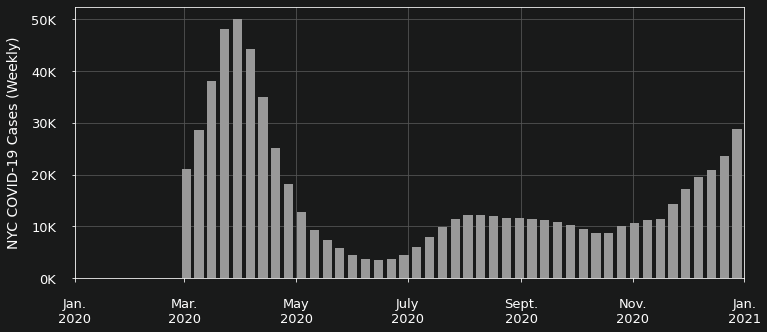

In [28]:
plot(light=False)

In [33]:
may2020_df = total_df.copy()
may2020_df = may2020_df[may2020_df.index >= pd.to_datetime('2020-05-01 00:00:00-05:00')]
may2020_df = may2020_df[may2020_df.index <= pd.to_datetime('2020-05-31 00:00:00-05:00')]
may2019_df = total_df.copy()
may2019_df = may2019_df[may2019_df.index >= pd.to_datetime('2019-05-01 00:00:00-05:00')]
may2019_df = may2019_df[may2019_df.index <= pd.to_datetime('2019-05-31 00:00:00-05:00')]
peek(may2020_df)
peek(may2019_df)

,visitor_count,estimated_visitor_count
index,,
2020-05-04 00:00:00-04:00,502415.333333,1.775743e+06
2020-05-11 00:00:00-04:00,527298.000000,1.809846e+06
2020-05-18 00:00:00-04:00,550420.333333,1.873356e+06


4


,visitor_count,estimated_visitor_count
index,,
2019-05-06 00:00:00-04:00,1.565910e+06,3.679528e+06
2019-05-13 00:00:00-04:00,1.540464e+06,3.711040e+06
2019-05-20 00:00:00-04:00,1.513541e+06,3.699872e+06


4


In [35]:
median2020 = may2020_df['estimated_visitor_count'].median()
median2019 = may2019_df['estimated_visitor_count'].median()
print(median2020)
print(median2019)
print((median2020 - median2019) / median2019)

1841600.9597732944
3705455.7343260953
-0.5030028445048411


In [42]:
covid_borough_df = pd.read_csv('./data/cases-by-day.csv')
covid_borough_df = covid_borough_df.rename(columns={
    'BX_CASE_COUNT': 'bx',
    'BK_CASE_COUNT': 'bk',
    'MN_CASE_COUNT': 'mn',
    'SI_CASE_COUNT': 'si',
    'QN_CASE_COUNT': 'qn',
    'date_of_interest': 'date',
})
boroughs = ['bx', 'bk', 'mn', 'si', 'qn']
covid_borough_df = covid_borough_df[['date'] + boroughs]
covid_borough_df['date'] = pd.to_datetime(covid_borough_df['date']).dt.tz_localize('US/Eastern')
covid_borough_df['week'] = covid_borough_df['date'].dt.week
covid_borough_df = covid_borough_df.groupby(by=['week']).agg({
    'date': 'first',
    'bx': 'sum',
    'bk': 'sum',
    'mn': 'sum',
    'si': 'sum',
    'qn': 'sum',
}).reset_index()
covid_borough_df = covid_borough_df.sort_values(by=['date'])
covid_borough_df[boroughs] = covid_borough_df[boroughs].rolling(3, center=True).mean()
# Drop first week. It doesn't start on Monday and it's NaN due to rolling average.
covid_borough_df = covid_borough_df.iloc[1:, :]
covid_borough_df = covid_borough_df.set_index('date')
covid_borough_df = covid_borough_df[boroughs]

In [45]:
covid_borough_df['bx'] /= (1435068 / 100000)
covid_borough_df['bk'] /= (2589966 / 100000)
covid_borough_df['mn'] /= (1631991 / 100000)
covid_borough_df['si'] /= (474890 / 100000)
covid_borough_df['qn'] /= (2287377 / 100000)

<AxesSubplot:xlabel='date'>

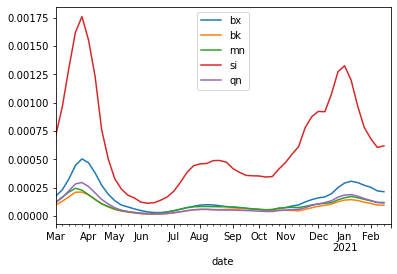

In [46]:
covid_borough_df.plot()